In [581]:
%matplotlib inline
import sys
sys.path.insert(0, '/Users/ulfaslak/Dropbox/school/sem11/Advanced\ Project\ in\ Digital\ Media\ Engineering/Code/Infomap/build/py')
import pandas as pd
import datetime as dt
import math
import matplotlib.pylab as plt
import seaborn as sns
from collections import Counter
from igraph import Graph
import igraph
import numpy as np
import datetime as dt
from pyinfomap import infomap
import networkx as nx
import matplotlib.colors as colors
from itertools import islice
import pickle
import subprocess
import re
import seaborn as sns

# Data

In [4]:
# Load 1 day data
def load_raw_day_data():
    df_short = pd.read_csv('../Data/raw_data/bluetooth_2014-02-05_short.csv', sep=" ")
    df_all = pd.read_csv('../Data/raw_data/bluetooth_2014-02-05_all.csv', sep=" ")
    return df_short, df_all

# df_short, df_all = load_raw_dat_data()

In [7]:
# Load 1 month data
def load_raw_month_data():
    df_short = pd.read_csv('../Data/raw_data/short.csv', sep=" ").loc[:,['#','user1','user2','timestamp']]
    df_all = pd.read_csv('../Data/raw_data/all.csv', sep=" ").loc[:,['#','user1','user2','timestamp']]

    # Fix bad column name assignment
    df_all.columns = ['user1','user2','timestamp','duration']
    df_short.columns = ['user1','user2','timestamp','duration']
    
    return df_short, df_all

df_short, df_all = load_raw_month_data()

#0. Functions

### General strategy
Partition network into many smaller networks seperated in time, i.e. bins. Perform community detection on each of these partitions (or bins if you will) and match the communities over time to see how individuals persist in group over time.

#### Functions for handling data

In [1186]:
def time_bin_network(df, window=3600):
    """Return iterator to partition network in 'window'-sized bins.
    
    Parameters
    ----------
    df : network dataframe
        Pandas dataframe with network loaded straight from csv.
    window : bin-size integer
        Size of network bins in seconds. This number controls
        the amount of bins.
        
    Returns
    -------
    df_slice : iterator
        Iterator object that yields one bin at a time.
    """
    print "-> time_bin_network\n\t",
    
    try:
        assert window >= 300
        window += 0.01
    except AssertionError:
        raise AssertionError("""'window' must be greater than, \
or equal to 300.""")
        
    # Get timestamp column and extreme values
    col_t = df["timestamp"]
    min_t = min(col_t)
    max_t = max(col_t)    
    
    # Get timespan and number of network splits
    delta_time = max_t - min_t
    
    n_splits = int(math.ceil(delta_time/float(window)))

    for i in range(n_splits):
        lower_bound = df["timestamp"] > min_t + i*window
        upper_bound = df["timestamp"] < min_t + (i+1)*window
        df_slice = df[lower_bound][upper_bound]
        yield df_slice

In [1187]:
def dump_binned_network(df, binsize, filename):
    """Store binned network into local file
    
    Parameters
    ----------
    df : network dataframe
        Pandas dataframe with network
    binsize : int
        Size of bins in resulting network
    filename : str
        Name of resulting file
    """
    print "-> dump_binned_network\n\t",
    
    binned_network = list(time_bin_network(df, window=binsize))
    
    with open('../Data/processed_data/binned_networks/'+filename+'.pickle', 'w') as outfile:
        pickle.dump(binned_network, outfile)

In [1188]:
def load_binned_network(kind,filename):
    """Load binned network from local file
    
    Parameters
    ----------
    kind : name-string
        Either 'short' or 'all'. Decides which dataset
        to load from.
    filename : name-string
        Name relating to the span of each bin in the
        partitioned network.
    """
    print "-> load_binned_network\n\t",
    
    with open('../Data/processed_data/binned_networks/'+kind+'/'+filename+'.pickle', 'r') as infile:
        return pickle.load(infile)

In [1189]:
def create_loadable_bins():
    """Store a series of binned networks locally
    """
    print "-> create_loadable_bins\n\t",
    
    bins = [300, 900, 1800, 3600, 86400, 604800]
    bin_names = ['5mins', '15mins', '30mins', 'hourly', 'daily', 'weekly']
    dataframes = [df_short, df_all]
    dataframe_names = ['_short', '_all']

    for df_, dfn_ in zip(dataframes,dataframe_names):
        for b,n in zip(bins,bin_names):
            print dfn_,n
            dump_binned_network(df_,b,n+dfn_)

#### Functions for reformatting the data

In [1190]:
def network_reformat(df, output_format='graph', node_format="hash", weighted=True):
    """Return re-formattated representation of network
    
    Parameters
    ----------
    df : network dataframe
        Pandas dataframe with network.
    weighted : boolean
        If true adds weights to edges corresponding to
        number of times each one occurs. If False, multi
        edges are disregarded. Defaults to True.
        
    Returns
    -------
    nodes, edges : list, list of tuples
        The network in a format which works with igraph or networkx,
        where nodes are either hash values or ints.
    net_file : string
        A string in .net format, representing the input
        network
    """
    print "-> network_reformat\n\t",
    
    # Asserting that inputs are correct types
    output_format_allowed = ['graph','net']
    try:
        assert output_format in output_format_allowed
    except AssertionError:
        raise AssertionError("Error: 'output_format' must be %s or %s." % tuple(output_format_allowed))
        
    node_format_allowed = ['hash','int']
    try:
        assert output_format in output_format_allowed
    except AssertionError:
        raise AssertionError("Error: 'node_format' must be %s or %s." % tuple(output_format_allowed))
        
    try:
        assert type(weighted) is bool
    except AssertionError:
        raise AssertionError("Error: 'weighted' parameter must be bool.")
    
    
    
    # Get unique nodes and sort
    nodes_hash = sorted(set(list(df["user1"])+list(df["user2"])))
    edges_hash = zip(df["user1"], df["user2"])
    
    
    
    # Assign weights to edges
    if weighted: 
        edges_hash = [(k[0],k[1],v) for k,v in Counter(edges_hash).items()]
    else:
        edges_hash = [(k,v,1) for k,v in set(edges_hash)]

        
    
    # Set node format (either 'int' or 'hash')
    if node_format == "int":
        
        # Create integer names for each nodes
        nodes_int  = range(1,len(nodes_hash)+1)

        # Mapping between hash-id with int-id
        hash_to_int = dict(zip(nodes_hash,nodes_int))
        
        # Get edges with int-ids. Sort for first node in each links
        edges_int = sorted(
            [(hash_to_int[i],hash_to_int[j],k) for (i,j,k) in edges_hash]
             , key=lambda x: x[0])
        
        # Conform to return-variable names
        nodes = nodes_int
        edges = edges_int
        
    elif node_format == "hash":
        
        # Sorting for good measure - not vital
        edges_hash = sorted(edges_hash, key=lambda x: x[0])
        
        # Conform to return-variable names
        nodes = nodes_hash
        edges = edges_hash
        
    else:
        # This code should never execute. Kept for debugging.
        raise AssertionError("Error: 'node_format' must be either 'int' or 'hash'.")
    
    if output_format == "graph":
        return nodes, edges
        
    # Build output .net formatted network string.
    net_file = "*Vertices %d" % len(nodes)
    for i,n in enumerate(nodes):
        net_file += '\n%d "Node %s" 1.0' % (i+1,str(n))
        
    # Add edges
    net_file += "\n*Arcs %d" % len(edges)
    for i, e in enumerate(edges):
        net_file += '\n%s %s %s' % (str(e[0]),str(e[1]),e[2])
    
    return net_file

In [1191]:
def network_reformat_multiplex(halflife=-1,node_representation="physical",*args):
    """Return multiplex representation of multiplex network
    
    Parameters
    ----------
    halflife : number
        Halflife in seconds of relax-rate decay between layers.
        Defaults to -1.
    node_representation : string
        Set to "state if state nodes associated with the same physical
        node should have different reference names. Defaults to "physical".
    *args : pandas df formatted layer(s)
        
    Returns
    -------
    net_file : string
        A network string in multiplex format
    int_to_hash : dict
        Key-value pairs of node integer id and original hash id
    """
    print "-> network_reformat_multiplex\n\t",
    
    # Infomap will only work with node indices on the command line.
    
    # Pool all nodes and sort the set
    nodes_hash = []
    for l, df in enumerate(args):
        layer_nodes = set()
        layer_nodes.update(df["user1"])
        layer_nodes.update(df["user2"])
        
        if node_representation == "state":
            # Add layer identifier to end of each node hash
            layer_nodes = [hash_str+"_"+str(l+1) for hash_str in layer_nodes]    
        nodes_hash.extend(layer_nodes) # no good reason to sort them
        
    if node_representation == "physical":
        nodes_hash = sorted(set(nodes_hash)) # no good reason not to sort them
    
    nodes = range(1,len(nodes_hash)+1)
    hash_to_int = dict(zip(nodes_hash,nodes))
    int_to_hash = dict(zip(nodes,nodes_hash))
    
    # Add vertices to output file string
    out_file = "*Vertices %d" % len(nodes)
    
    for i,n in enumerate(nodes):
        out_file += '\n%d "Node %s" 1.0' % (i+1,str(n))
        
    # Add edges to output file string
    out_file += "\n*Multiplex"
    
    for l, df in enumerate(args):
        if node_representation == "state":
            user1 = [hash_str+"_"+str(l+1) for hash_str in df["user1"]]
            user2 = [hash_str+"_"+str(l+1) for hash_str in df["user2"]]
        else:
            user1 = df["user1"]
            user2 = df["user2"]
            
        edges_hash = zip(user1, user2)
        
        # Add weights
        edges_hash = sorted([(e[0],e[1],w) for e,w in Counter(edges_hash).items()], key=lambda x: x[0])
        
        # Get edges with int-ids. Sort for first node in each links
        edges = sorted(
            [(hash_to_int[i],hash_to_int[j],w) for (i,j,w) in edges_hash]
             , key=lambda x: x[0])
        
        # Add edges
        for i,j,w in edges:
            out_file += '\n%d %s %d %s %d' % (l+1,str(i),l+1,str(j),w) #+1 because 1 is first layer index
            
    # Add interlayer relax-rates - if halflife is not infinte (represented as -1)
    if halflife == -1:
        return out_file, int_to_hash
    
    # Relax decay function
    def N(t):
        tau = halflife/np.log(2)
        return np.exp(-t/float(tau))
    
    # Add inter-statenode relax rates
    if node_representation == "state":
        nodes_hash_set = set([hash_str_id.split("_")[0] for hash_str_id in nodes_hash])
        error_count = 0
        for n in nodes_hash_set:
            for l1, df1 in enumerate(args):
                for l2, df2 in enumerate(args):
                    if l2 > l1:
                        try:
                            n1 = hash_to_int[n+"_"+str(l1+1)]
                            n2 = hash_to_int[n+"_"+str(l2+1)]
                            time_diff = df2['timestamp'].values[0] - df1['timestamp'].values[0]
                            out_file += '\n%d %s %d %s %f' % (l1+1,n1,l2+1,n2,N(time_diff))
                        except KeyError:
                            # Will fail a few times because the algorithm tries all nodes
                            # in all layers, when some layers don't have all nodes.
                            error_count += 1
        print "\t exception count:", error_count
        #print sum([len(nodes_hash_set - set(list(df['user1'])+list(df['user2'])))
        #       for df in args])
                        
    else:
        for n in nodes:
            for l1, df1 in enumerate(args):
                for l2, df2 in enumerate(args):
                    if l2 > l1:
                        time_diff = df2['timestamp'].values[0] - df1['timestamp'].values[0]
                        out_file += '\n%d %s %d %s %f' % (l1+1,n,l2+1,n,N(time_diff))

    return out_file, int_to_hash

#### Functions for community detection

In [1192]:
def community_detection_single_layer(nodes,edges,kind="list"):
    print "-> community_detection_single_layer\n\t",
    
    hash_to_int = dict(zip(nodes,range(len(nodes))))
    int_to_hash = dict(zip(range(len(nodes)),nodes))
    
    conf = infomap.init("--two-level");
    
    # Input data
    network = infomap.Network(conf);
    
    # Output data
    tree = infomap.HierarchicalNetwork(conf)
    
    unweighted_edges = [(hash_to_int[k],hash_to_int[v]) for (k,v,w) in edges]
    weighted_edges = [(hash_to_int[k],hash_to_int[v], w) for (k,v,w) in edges]
    for e in weighted_edges:
        network.addLink(*e)

    network.finalizeAndCheckNetwork(True, len(nodes));

    # Cluster network
    infomap.run(network, tree);

    communities = {}
    clusterIndexLevel = 1 # 1, 2, ... or -1 for top, second, ... or lowest cluster level
    for node in tree.leafIter(clusterIndexLevel):
        communities[node.originalLeafIndex] = node.clusterIndex()
        
    if kind == "dict":
        return communities
    
    # Format to list of lists with hash values
    communities_hash = [[] for _ in range(max(communities.values())+1)] # +1 because 0 counts too
    communities_hash[0].append(int_to_hash[26])
    for (k,v) in communities.items():
        communities_hash[v].append(int_to_hash[k])
    return communities_hash

#---------------------
    nx.set_node_attributes(G, 'community', communities)
    return tree.numTopModules()

In [1205]:
def community_detection_multiplex(halflife=-1, node_representation="physical", *args):
    """Run multiplex community detection because Python implementation has no docs
    
    Parameters
    ----------
    halflife : number
        Halflife in seconds of relax-rate decay between layers.
        Defaults to -1.
    node_representation : string
        Set to "state if state nodes associated with the same physical
        node should have different reference names. Defaults to "physical".
    *args : layers (pandas dfs)
    
    Returns
    -------
    communities : list of lists
    """
    print "-> community_detection_multiplex\n\t",
    
    def parse_communities():
        with open('output/'+multiplex_network_filename+".clu", 'r') as infile:
            multiplex_network_clusters = infile.read()

        # Get nodes and clusters from .clu file string
        tmp1 = re.findall(r'\d+ \d+ \d.\d+', multiplex_network_clusters) # [[30, 1, 0.00800543],...]
        tmp2 = [tuple(i.split()[:2]) for i in tmp1] # [(30, 1),...]

        # Formatting
        communities = [[] for _ in [[]]*max([int(i[1]) for i in tmp2])] #Alike to [[]]*max... (trick to avoid mutability)
        for i,j in tmp2:
            communities[int(j)-1].append(int(i)) #-1 because j starts at 1

        # Map from node ints to node hashes
        communities_list = [[int_to_hash[n] for n in c] for c in communities]
        
        return communities_list
    
    def parse_node_flow_from_tree():
        with open('output/'+'multiplex-network'+".tree", 'r') as infile:
            multiplex_network_tree = infile.read()

        # Get flow for each node from .tree file
        return [float(i) for i in re.findall(r'0\.\d+', multiplex_network_tree)]
    
    def parse_module_flow_from_map():
        with open('output/'+'multiplex-network'+".map", 'r') as infile:
            multiplex_network_tree = infile.read()

        # Get flow for each node from .tree file
        module_flow =  [float(j) for j in re.findall(r'0\.\d+ ', multiplex_network_tree)]
        exit_flow =  [float(j.split()[1]) for j in re.findall(r'0\.\d+ \d.+', multiplex_network_tree)]

        return module_flow, exit_flow
    
    # Get network in mutliplex string format and define filename
    multiplex_network, int_to_hash = network_reformat_multiplex(halflife, node_representation, *args)
    multiplex_network_filename = 'multiplex-network'

    # Store locally
    with open("input/"+multiplex_network_filename+".net", 'w') as outfile:
        outfile.write(multiplex_network)
    
    # Run Infomap for multiplex network
    subprocess.call(['./Infomap/Infomap', 'input/'+multiplex_network_filename+".net", 'output/', '-i', 'multiplex', '--two-level', '--map', '--clu', '--tree', '--btree', '--bftree'])
    
    communities_list = parse_communities()
    
    return communities_list, parse_node_flow_from_tree(), parse_module_flow_from_map()

#### Functions for layer community matching

In [1195]:
def community_matching(c_a, c_b):
    """Return reoccuring individuals within communities between layers
    
    Parameters
    ----------
    c_a : list of lists
        Communities in first layer. Type-wise it is the same 
        as the output from 'community_detection_igraph' or 
        'community_detection_single_layer' functions.
    c_b : list of lists
        Communities in second layer.
        
    Returns
    -------
    matching_communities : list of lists
        Community members in respective communities which are
        persistent across the two layers.
    """
    print "-> community_matching\n\t",
    
    if len(c_b) == 0:
        return [[]]
    
    matching_communities = []
    for c_ai in c_a:
        matches  = []
        lengths = []
        for c_bi in c_b:
            match  = list(set(c_ai) & set(c_bi))
            length = len(match)
            matches.append(match)
            lengths.append(length)
            
        # Append biggest matching if bigger than 1
        longest_match = matches[lengths.index(max(lengths))]
        if len(longest_match) > 1:
            matching_communities.append(longest_match)
    
    return matching_communities

In [1196]:
def get_matchings_recursively(df, matching_depth, window=3600, layers=None):
    """Return interlayer matchings
    
    Parameters
    ----------
    df : network dataframe
        Pandas dataframe with network loaded straight from csv.
    matching_depth : int/'max'
        Number of successing layers which each layer is matched with.
        Maximum value is restricted by natural number of layers, which
        is governed by 'window' parameter, due to 'if c_a >= 0' statement
        in code. In other words, very large numbers default to 'max'.
    window : bin-size integer
        Size of network bins in seconds. This number controls
        the amount of layers.
        
    Returns
    -------
    matchings : list of layer-matchings for each layer (default 24 layers).
        A list that contains a list of lists of lists element for each
        layer in the multi-layer network. matchings[i] would thus be a list
        of lists of lists corresponding to all layer-wise matchings for layer
        number i. matchings[i][j] would be the matching between layer i and j.
        matching[i][j][k] would be the list of members in group k which were
        persistent in their group across time slices i and j.
        
    """
    print "-> get_matchings_recursively\n\t",
    
    if layers != None:
        layers = layers
    else:
        layers = time_bin_network(df, window=window) # This call takes considerable time

    layer_communities = []
    matchings = []

    for d, l in enumerate(layers):
        nodes, edges = network_reformat(l, weighted=True, output_format='graph',node_format="hash")
        layer_communities.append(community_detection_single_layer(nodes,edges))
        matchings.append([])
        for i in reversed(range(matching_depth)):
            c_a = d-(i+1)
            if c_a >= 0:
                matchings[c_a].append(community_matching(layer_communities[c_a],layer_communities[d]))
                
    return matchings

In [1197]:
def get_matchings(df, reference_layer, matching_depth, window=3600, layers=None):
    """Return 'matching_depth' successing matchings with 'reference_layer'
    
    Parameters
    ----------
    df : network dataframe
        Pandas dataframe with network loaded straight from csv.
    reference_layer : layer-id (int)
        Particular layer/bin/slice which should be matched with
        'matching_depth' number of successing layers.
    matching_depth : int
        Number of successing layers which reference layer is matched with.
        Maximum value is restricted by natural number of layers, which
        is governed by 'window' parameter, due to 'if c_a >= 0' statement
        in code. In other words, very large numbers default to a max value.
    window : bin-size integer
        Size of network bins in seconds. This number controls
        the amount of layers.
    layers : list of network dataframes
        Optional parameter, which can be used to input an already binned
        network. Using this parameter will make this function run much
        faster, because the bottleneck is the use of the 'time_bin_network'
        function (i.e. getting each layer to me matched against each other).
        
    Returns
    -------
    matchings : list of layer-matchings for each layer (defaults to max layers).
        A list that contains a list of lists element for each layer in the 
        multi-layer network. matchings[j] would be the matching between the
        reference_layer and layer j. matching[j][k] would be the list of members
        in group k which were persistent in their group across time slices
        'reference_layer' and j.
        
    """
    print "-> get_matchings\n\t",
    
    if layers != None:
        
        layers = layers
        
        # Check that layers has correct window
        min_t = min(layers[1]['timestamp'])
        max_t = max(layers[1]['timestamp'])
        
        layer_window = (max_t - min_t) + 300 # There's always a 300s offset!
        
        try:
            assert layer_window == window
        except AssertionError:
            print "Warning: Wrong 'window' paramter provided. \
Provided 'layers' has window size %d. Continuing as if window \
= %d." % (layer_window, layer_window)
            #layers = time_bin_network(df, window=window) # This call takes considerable time
        
    else:
        layers = time_bin_network(df, window=window) # This call takes considerable time
    

    layer_communities = []
    matchings = []
    
    valid_range = range(reference_layer,reference_layer+matching_depth)
    
    d = 0
    for l in layers:
        if d in valid_range:
            nodes, edges = network_reformat(l, weighted=True, output_format='graph',node_format="hash")
            layer_communities.append(community_detection_single_layer(nodes,edges))
        d += 1

    for i,_ in enumerate(layer_communities):
        matchings.append(community_matching(layer_communities[0],layer_communities[i]))
                                  

    return matchings

In [1410]:
def get_layer_similarity(i,j,layers, communities,verbose=False):
    if verbose:
        print "-> get_layer_similarity\n\t",
    
    common_nodes = set(list(layers[i]['user1']) + list(layers[i]['user2'])) & set(list(layers[j]['user1']) + list(layers[j]['user2']))
    
    sim_counter = 0
    #for co in communities:
    #    for no in common_nodes:
    #        if len(set(co) & {no+"_%d"%i,no+"_%d"%j}) == 2:
    #            sim_counter += 1
    
    agg_nodes = []
    for co in communities:
        nodes = [n.split("_")[0] for n in co if int(n.split("_")[1]) in [i,j]]
        sim_counter += len([1 for v in Counter(nodes).values() if v == 2])
        agg_nodes.extend(nodes)


    if sim_counter == 0:
        print "sim_counter == 0"
        return 0
    
    
    return Counter(agg_nodes)
    print 
    return sim_counter / float(len(common_nodes))

In [1411]:
time get_layer_similarity(1,5,layers,communities)

CPU times: user 23.3 ms, sys: 3.56 ms, total: 26.9 ms
Wall time: 24.4 ms


['85ae772e4de64975d62be4ba1b41e8',
 '85ae772e4de64975d62be4ba1b41e8',
 'c4d85dcf180ac803749f03c68c941e',
 'c4d85dcf180ac803749f03c68c941e',
 '658289f8dc454ef88136ba29558854',
 '658289f8dc454ef88136ba29558854',
 '51bbc59b59c49e7af848d5172ede97',
 '51bbc59b59c49e7af848d5172ede97',
 '75e3669e556859f5610a985431264a',
 '75e3669e556859f5610a985431264a',
 '12ec66058d1902e7b7ec6ab28cf856',
 '12ec66058d1902e7b7ec6ab28cf856',
 '8216b2c7553c9c95b1f7a2c0eaea87',
 '8216b2c7553c9c95b1f7a2c0eaea87',
 'a86f60d62eaad69ef35e36650fc10b',
 'a86f60d62eaad69ef35e36650fc10b',
 'b7b98e1489e735d8ce4d30348efcc9',
 'b7b98e1489e735d8ce4d30348efcc9',
 '7942ad3b074c140ea3a3f87e60af0e',
 '7942ad3b074c140ea3a3f87e60af0e',
 '52abc212c35d14baad756836df8637',
 '1312d7f4ed5089cb37d85c47288231',
 '52abc212c35d14baad756836df8637',
 '1312d7f4ed5089cb37d85c47288231',
 '29d07c9c3db687d13720b5041d5139',
 '29d07c9c3db687d13720b5041d5139',
 '1074f7c8efee6dc8bbc5ec7ad89442',
 '1074f7c8efee6dc8bbc5ec7ad89442',
 '15f2df470e3660b75f

In [1373]:
time get_layer_similarity_o(1,5,layers,communities)

CPU times: user 36.1 ms, sys: 3.54 ms, total: 39.6 ms
Wall time: 36.9 ms


0.7333333333333333

In [1408]:
c_flat = [item for sublist in communities for item in sublist]
x = []
for index in range(len(layers)):
    c_rele = [n.split("_")[0] for n in c_flat if int(n.split("_")[1]) in [index]]
    if len([2 for i in Counter(c_rele).values() if i==2]) > 0:
        print index
    x.append(len(c_rele))

#### Plotting and graphing functions

In [1199]:
def community_decay(matchings,window,reference_time=0):
    """Plot community decay in reference to specific time
    
    Parameters
    ----------
    matchings : list of layer-matchings for each layer (default 24 layers).
        A list that contains a list of lists of lists element for each
        layer in the multi-layer network. matchings[i] would thus be a list
        of lists of lists corresponding to all layer-wise matchings for layer
        number i. matchings[i][j] would be the matching between layer i and j.
        matching[i][j][k] would be the list of members in group k which were
        persistent in their group across time slices i and j.
    reference_time : int
        Time slice used as reference point. Data used for plots is based only
        on matchings[reference_time], and as such every other data point
        counts the number of people are still in their "original" communities.
    window : bin-size integer
        Size of network bins in seconds. This number controls
        the times printed on the x-axis. Should be consistent with 'window'
        argument passed to 'get_matchings' or 'get_all_matchings' for retrieval of 'matchings' parameter
        used in this function.
    """
    print "-> community_decay\n\t",
    
    if type(matchings[0][0][0]) == list:
        y = [sum([sum([1 for i in tmp]) for tmp in tmpp]) for tmpp in matchings[reference_time]]
        x = [t + dt.timedelta(0,window*i) for (i,t) in enumerate([dt.datetime.strptime("1","%d") + dt.timedelta(0,window*reference_time)]*(len(y)))]
    else:
        y = [sum([sum([1 for i in tmp]) for tmp in tmpp]) for tmpp in matchings]
        x = [t + dt.timedelta(0,window*i) for (i,t) in enumerate([dt.datetime.strptime("1","%d")]*(len(y)))]

    plt.figure(figsize=(16,8))
    plt.plot_date(x,y)
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Reoccuring members from time slice %d' % reference_time, fontsize=16)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.show

In [1200]:
def drawNetwork(G,k_):
    print "-> drawNetwork\n\t",
    # position map
    pos = nx.graphviz_layout(G,prog='neato', k=k_)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # weights
    weights = [G.get_edge_data(i,j)['weight'] for (i,j) in G.edges()]
    weights_transformed = np.log(np.array(weights))**3+100    
    
    # edges
    nx.draw_networkx_edges(G, 
                           pos,
                           width=np.array(weights_transformed)/max(weights_transformed)
                          )

    # nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Print node labels separately instead
    for n in G.nodes_iter():
        plt.annotate(communities[n],
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 2],
            color = cmapDark(communities[n])
        )

    plt.axis('off')
    #plt.savefig("netw.png")

In [1201]:
def draw_network_communities(G,k_):
    print "-> draw_network_communities\n\t",
    
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    num_communities = max(communities) + 1
    
    G_communities = nx.Graph()
    
    # Find nodes in the community network (straight forward)
    community_nodes = list(set(communities))
    
    # Find edges in the community network (slightly more complicated)
    community_edges = {} #Hash table because it makes collapsing edges easier
    internal_edges = [0] * num_communities #Counting num of links within each cluster

    for (i,j) in G.edges():
        
        c_i = communities[i]
        c_j = communities[j]
        
        w_ij = G.get_edge_data(i,j)['weight']
        
        if c_i != c_j:
            key = ' '.join([str(num) for num in sorted([c_i,c_j])]) # Example: '1 2'
            if key not in community_edges:
                community_edges[key] = w_ij
            else:
                community_edges[key] += w_ij
        else:
            internal_edges[c_i] += w_ij
    
    community_edges = [tuple([int(e) for e in k.split(" ")]+[v]) for (k,v) in community_edges.items()] # Horrible I know..
    
    G_communities.add_nodes_from(community_nodes)
    G_communities.add_weighted_edges_from(community_edges)
    
    
    ###############
    # BOILERPLATE #
    ###############
    
    pos = nx.spring_layout(G_communities, k=k_, iterations=10)
    
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', num_communities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', num_communities)

    # edges
    weights_transformed = np.log(np.array([w for (i,j,w) in community_edges]))**3+100
    nx.draw_networkx_edges(G_communities, 
                           pos,
                           width=weights_transformed/max(weights_transformed)
    )

    # nodes
    nodeCollection = nx.draw_networkx_nodes(G_communities,
        pos = pos,
        node_color = G_communities.nodes(),
        cmap = cmapLight,
        node_size = ((np.array(internal_edges))*1.85/(np.array(internal_edges)).max()+0.15)*1000
    )
    # set node border color to the darker shade
    darkColors = [cmapDark(v) for v in G_communities.nodes()]
    nodeCollection.set_edgecolor(darkColors)
    
    # Node labels
    for n in G_communities.nodes_iter():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 2],
            color = cmapDark(n)
        )

    plt.axis('off')
    #plt.savefig("netw.png")

# 1. Single layer clustering and simple matchings

### No magic: Plot number of connections over all bins

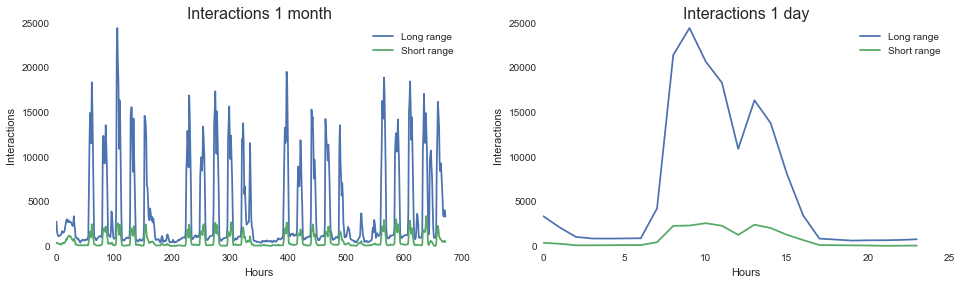

In [23]:
# Get binned networks from 'short' and 'all'
month_all_hourly = load_binned_network('1month_data','hourly_all')
month_sho_hourly = load_binned_network('1month_data','hourly_short')

day_all_hourly = load_binned_network('1day_data','hourly_all')
day_sho_hourly = load_binned_network('1day_data','hourly_short')

# Plot data to see that partition went well
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.title('Interactions 1 month', fontsize=16)
y_all = [len(w) for w in month_all_hourly]
y_sho = [len(w) for w in month_sho_hourly]
plt.plot(range(len(y_all)),y_all,label="Long range")
plt.plot(range(len(y_sho)),y_sho,label="Short range")
plt.xlabel("Hours")
plt.ylabel("Interactions")
plt.legend()

plt.subplot(1,2,2)
plt.title('Interactions 1 day', fontsize=16)
y_all = [len(w) for w in day_all_hourly]
y_sho = [len(w) for w in day_sho_hourly]
plt.plot(range(len(y_all)),y_all,label="Long range")
plt.plot(range(len(y_sho)),y_sho,label="Short range")
plt.xlabel("Hours")
plt.ylabel("Interactions")
plt.legend()

plt.show()

## Visualise single layers in network

In [24]:
# Load all the monthly data. Aggressive, I know.
#month_all_5mins = load_binned_network('1month_data','5mins_all')
#month_sho_5mins = load_binned_network('1month_data','5mins_short')
#month_all_15mins = load_binned_network('1month_data','15mins_all')
#month_sho_15mins = load_binned_network('1month_data','15mins_short')
#month_all_30mins = load_binned_network('1month_data','30mins_all')
#month_sho_30mins = load_binned_network('1month_data','30mins_short')
month_all_hourly = load_binned_network('1month_data','hourly_all')
month_sho_hourly = load_binned_network('1month_data','hourly_short')
month_all_daily = load_binned_network('1month_data','daily_all')
#month_sho_daily = load_binned_network('1month_data','daily_short')
month_all_weekly = load_binned_network('1month_data','weekly_all')
#month_sho_weekly = load_binned_network('1month_data','weekly_short')

In [1003]:
nodes1, edges1 = network_reformat(month_all_hourly[9], weighted=True, output_format='graph',node_format="hash")
nodes2, edges2 = network_reformat(month_all_daily[2], weighted=True, output_format='graph',node_format="hash")
nodes3, edges3 = network_reformat(month_all_weekly[0], weighted=True, output_format='graph',node_format="hash")

hash_to_int1 = dict(zip(nodes1,range(len(nodes1))))
int_to_hash1 = dict(zip(range(len(nodes1)),nodes1))

hash_to_int2 = dict(zip(nodes2,range(len(nodes2))))
int_to_hash2 = dict(zip(range(len(nodes2)),nodes2))

hash_to_int3 = dict(zip(nodes3,range(len(nodes3))))
int_to_hash3 = dict(zip(range(len(nodes3)),nodes3))

G1 = nx.Graph()
G1.add_nodes_from([hash_to_int1[n] for n in nodes1])
G1.add_weighted_edges_from([(hash_to_int1[k],hash_to_int1[v],w) for (k,v,w) in edges1])
communities1 = community_detection_single_layer(nodes1,edges1,kind="dict")
nx.set_node_attributes(G1, 'community', communities1)

G2 = nx.Graph()
G2.add_nodes_from([hash_to_int2[n] for n in nodes2])
G2.add_weighted_edges_from([(hash_to_int2[k],hash_to_int2[v],w) for (k,v,w) in edges2])
communities2 = community_detection_single_layer(nodes2,edges2,kind="dict")
nx.set_node_attributes(G2, 'community', communities2)

G3 = nx.Graph()
G3.add_nodes_from([hash_to_int3[n] for n in nodes3])
G3.add_weighted_edges_from([(hash_to_int3[k],hash_to_int3[v],w) for (k,v,w) in edges3])
communities3 = community_detection_single_layer(nodes3,edges3,kind="dict")
nx.set_node_attributes(G3, 'community', communities3)

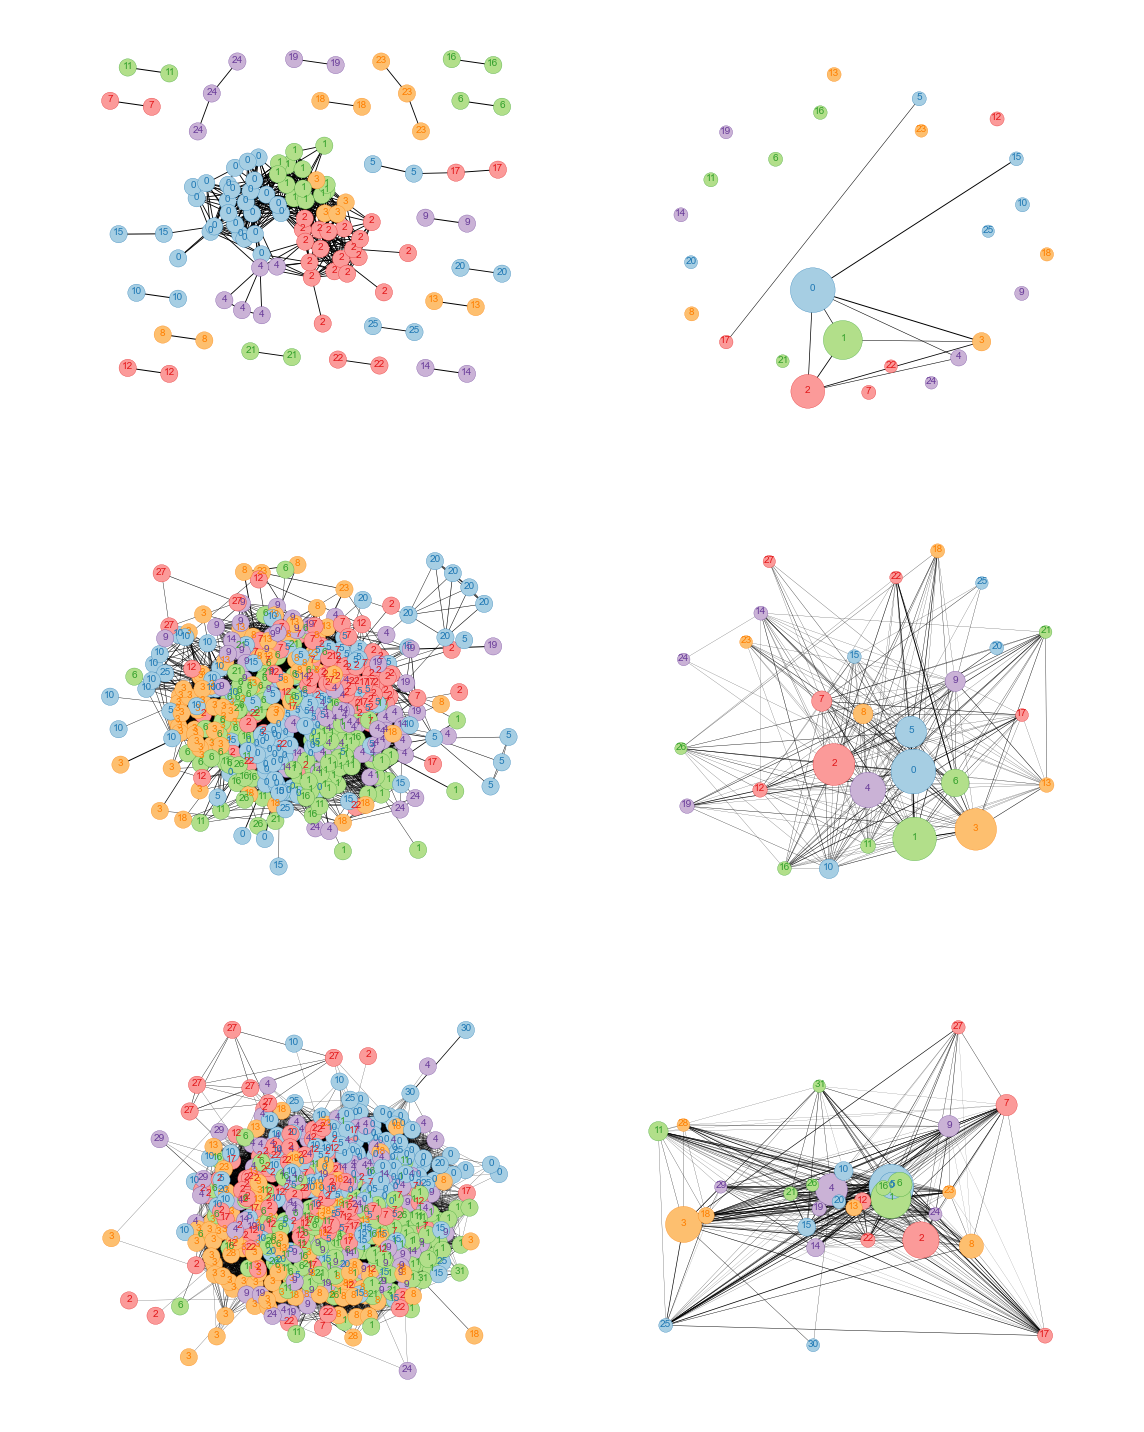

In [1095]:
plt.figure(figsize=(16,20))
plt.subplot(321)
drawNetwork(G1,k_=0.13)
plt.subplot(322)
draw_network_communities(G1,k_=1)
plt.subplot(323)
drawNetwork(G2,k_=0.18)
plt.subplot(324)
draw_network_communities(G2,k_=2.1)
plt.subplot(325)
drawNetwork(G3,k_=0.2)
plt.subplot(326)
draw_network_communities(G3,k_=1)
plt.tight_layout()
plt.show()

#### You can see that the clustering becomes more and more useless as the layer "time-thickness" increases. This makes sense, cause we would expect very few individuals to be part of the same clusters throughout a full day.

## Visualise community recurrence based on simple single layer community matching

In [403]:
#matchings_recursive = get_matchings_recursively(df_all,matching_depth=24,window=3600)

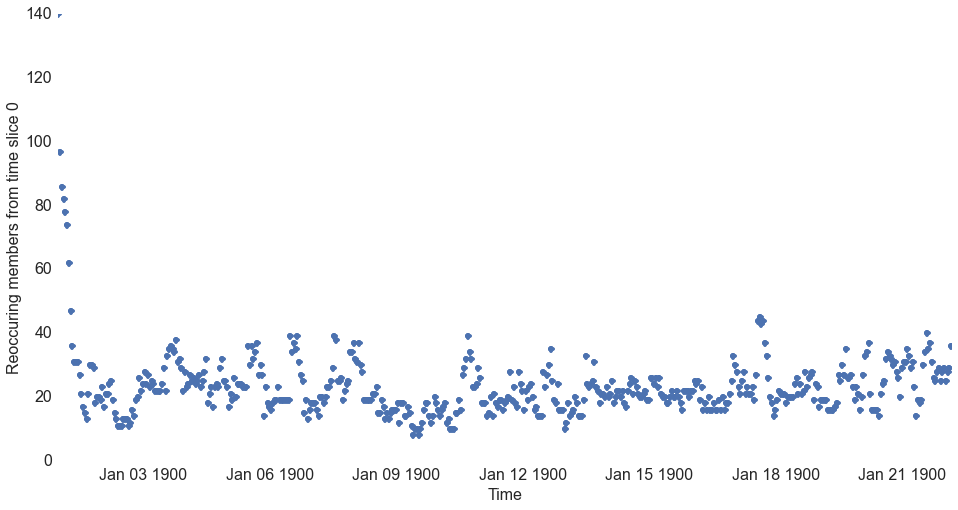

In [27]:
df_all = 'dummy' # The raw data is not needed because I provide processed data ('layers')
matchings_reference = get_matchings(df_all,reference_layer=163,matching_depth=10000,window=3600,layers=month_all_hourly)
community_decay(matchings_reference,window=3600)

## Robustness of communities emerging at different times

In [28]:
#def dont_run_this_it_takes_forever():
#layer_robustness = []
#layer_robustness_normed = []
h = 0
while True:
    if h < len(layer_robustness):
        continue
    matchings_reference = get_matchings(
        df_all,
        reference_layer=h,
        matching_depth=10000,
        window=3600,
        layers=month_all_hourly
        )

    try:
        rob = sum([
                sum(
                    [len(j) for j in matchings_reference[i]]
                   )
                for i in range(len(matchings_reference))
                ]) /float(len(matchings_reference))
        rob0 = sum([len(j) for j in matchings_reference[0]])
        layer_robustness.append(rob)
        layer_robustness_normed.append(rob/rob0)
        print h,
    except IndexError:
        print "stop"
        break
    except ZeroDivisionError:
        print h
        print matchings_reference
        break

    h+=1

#        return layer_robustness, layer_robustness_normed
    
#layer_robustness, layer_robustness_normed = dont_run_this_it_takes_forever()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

KeyboardInterrupt: 

In [ ]:
window = 3600
plt.figure(figsize=(16,6))
plt.plot(range(len(layer_robustness)),layer_robustness_normed)

# 2. Multiplex community detection

## 2.1 Reproduce Fig. 6 from De Domenico 2015

In [45]:
# Get data
month_all_hourly = load_binned_network('1month_data','hourly_all')

In [406]:
layers = []
for h in range(8,18):
    layers.append(month_all_hourly[h])
    
# Concatenate layers, for good measure
layers_stacked = pd.concat(layers,axis=0)

#### Computing functions 

In [1202]:
def calculate_overlap(communities):
    """Return overlap for a multilayer network partition
    
    Parameters
    ----------
    communities : list of lists
        Multilayer partition into communities
    
    Return
    ------
    overlap : float
        Average node module participation
    """
    print "-> calculate_overlap\n\t",
    
    flattened_communities = []
    for c in communities:
        flattened_communities.extend(c)

    overlap = len(flattened_communities)/float(len(set(flattened_communities)))
    
    return overlap


def calculate_modulesize(node_flow, module_flow):
    """Return modulesize for a multilayer network partition
    
    Parameters
    ----------
    flow : list
        Vector of flow values for each node in network
    
    Return
    ------
    modulesize : float
        Average node module participation size divided by number of nodes
    """
    print "-> calculate_modulesize\n\t",
    
    module_internal_flow = [i[0] for i in module_flow]
    module_exit_flow = [i[1] for i in module_flow]
    
    module_in_flow = [sum(module_internal_flow)+sum(module_exit_flow)-m[0]-m[1] for m in module_flow]
    
    P = module_internal_flow + module_exit_flow
    
    # Calculate Shannon's entropy
    H = -sum(np.array(P)*np.log2(P))
    n_nodes = len(node_flow)
    n_modules_eff = 2**H
    
    return n_nodes/n_modules_eff


def calculate_modulesize_simple(communities):
    """Return modulesize for a multilayer network partition
    
    Parameters
    ----------
    flow : list
        Vector of flow values for each node in network
    
    Return
    ------
    modulesize : float
        Average node module participation size divided by number of nodes
    """
    print "-> calculate_modulesize_simple\n\t",
    
    return float(len(set([item for sublist in communities for item in sublist])))/len(communities)

In [850]:
x = []
overlap = []
module_size = []
module_size1 = []
for halflife in [np.exp(i) for i in range(2,16)]:
    x.append(halflife)
    communities, node_flow, module_flow = community_detection_multiplex(halflife, False,*layers)
    overlap.append(calculate_overlap(communities))
    module_size.append(calculate_modulesize(node_flow, module_flow))
    module_size1.append(calculate_modulesize_simple(communities))
    
overlap = [i/overlap[-1] for i in overlap]
module_size = [i/module_size[-1] for i in module_size]
module_size1 = [i/module_size1[-1] for i in module_size1]

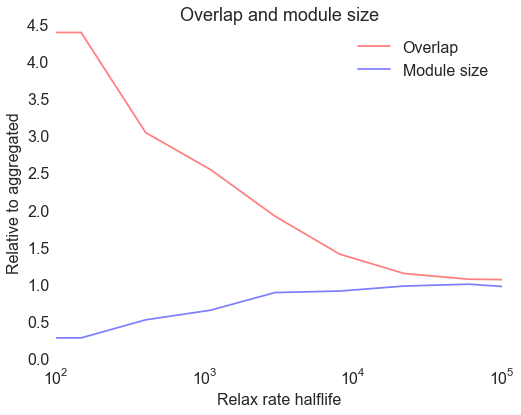

In [886]:
plt.figure(figsize=(8,6))

plt.plot(x,overlap,c="r",alpha=0.5, label="Overlap")
#plt.plot(x,module_size,c="g",alpha=0.5)
plt.plot(x,module_size1,c="b",alpha=0.5,label="Module size")
plt.title("Overlap and module size", fontsize=18)

plt.xlim(100,100000)
plt.xticks(fontsize=16)
plt.xlabel("Relax rate halflife",fontsize=16)
plt.xscale('log')

plt.yticks(fontsize=16)
plt.ylabel("Relative to aggregated",fontsize=16)

plt.legend(fontsize=16)
plt.show()

In [1001]:
with open('manual_inspection/aggregated_network.net', 'w') as outfile:
    outfile.write(network_reformat(layers_stacked, output_format='net', node_format="int", weighted=True))

1081

## Visualise one community at a time

In [1101]:
nodes, edges = network_reformat(layers_stacked, output_format='graph', node_format="hash", weighted=True)
communities, node_flow, module_flow = community_detection_multiplex(3600, False,*layers)
hash_to_int = dict(zip(nodes,range(len(nodes))))

# Construct graph
G = nx.Graph()
G.add_nodes_from([hash_to_int[n] for n in nodes])
G.add_weighted_edges_from([(hash_to_int[k],hash_to_int[v],w) for (k,v,w) in edges])

plt.figure(figsize=(16,1000))

rows = len(communities)/3+1
for i, c in enumerate(communities):

    color_communities = [hash_to_int[n] for n in c]
    grey_communities = [hash_to_int[n] for n in (set(nodes)-set(c))]

    com = dict((i,1) for i in color_communities)
    com.update(dict((i,0) for i in grey_communities))

    nx.set_node_attributes(G, 'community', com)

    plt.subplot(rows,2,i+1)
    drawNetwork(G,k_=0.13)
    
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

ValueError: width and height must each be below 32768

## Calculate layer similarities

In [1104]:
# Get data
#month_all_hourly = load_binned_network('1month_data','hourly_all')
day_sho_5mins = load_binned_network('1day_data','5mins_short')

In [ ]:
layers = []
for h in range(8,18):
    layers.append(month_sho_5mins[h])
    
# Concatenate layers, for good measure
layers_stacked = pd.concat(layers,axis=0)

In [1107]:
layers = day_sho_5mins

In [1208]:
communities, node_flow, module_flow = community_detection_multiplex(3600, "state",*layers)

-> community_detection_multiplex
	-> network_reformat_multiplex
		 exception count: 15728065


In [1235]:
dim = len(layers)
X = np.empty((dim,dim))
for i in range(dim):
    print i,
    for j in range(dim):
        if i == j:
            X[i,j] = 1.0
        if i > j:
            sim = get_layer_similarity(i,j,layers,communities, verbose=False)
            X[i,j] = sim
            X[j,i] = sim

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232

ZeroDivisionError: float division by zero

In [1250]:
get_layer_similarity(2,1,layers,communities)

IndexError: string index out of range

In [1074]:
get_layer_similarity(communities[2]['modules'],communities[1]['modules'])

0.44537815126050423

<matplotlib.colorbar.Colorbar instance at 0x320a39f38>

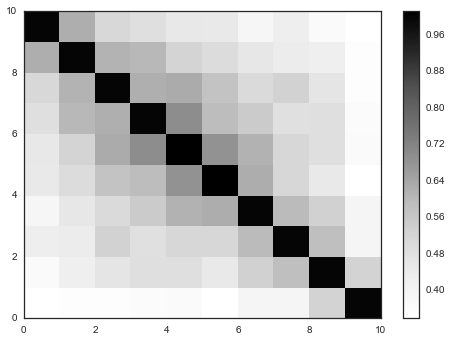

In [1100]:
plt.pcolor(X[:,::-1])
plt.colorbar()